In [1]:
# Suppress distracting outputs in these examples
import logging
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
logger = logging.getLogger("esmvalcore")
logger.setLevel(logging.WARNING)

# User guide

This user manual will explain how the eWaterCycle Python package can be used to perform hydrological experiments. We will walk through the following chapters:

- parameter sets
- forcing data
- model instances
- using observations
- analysis

Each of these chapters correspond to a so-called "subpackage" of eWaterCycle Python package. Before we continue, however, we will briefly explain the configuration file.

**Configuration**

To be able to find all needed data and models eWaterCycle comes with a configuration object. This configuration contains system settings for eWaterCycle (which container technology to use, where is the data located, etc). In general these should not need to be changed by the user for a specific experiment, and ideally a user would never need to touch this configuration on a properly managed system. However, it is good to know that it is there. 

You can see the default configuration on your system like so:

In [2]:
from ewatercycle import CFG

CFG

Config({'container_engine': 'singularity',
        'ewatercycle_config': PosixPath('/home/fakhereh/.config/ewatercycle/ewatercycle.yaml'),
        'grdc_location': PosixPath('/projects/0/wtrcycle/comparison/GRDC/GRDC_GCOSGTN-H_27_03_2019'),
        'output_dir': PosixPath('/scratch/shared/ewatercycle/user_guide'),
        'parameter_sets': {'lisflood_fraser': {'config': 'lisflood_fraser/settings_lat_lon-Run.xml',
                                               'directory': 'lisflood_fraser',
                                               'doi': 'N/A',
                                               'supported_model_versions': {'20.10'},
                                               'target_model': 'lisflood'},
                           'pcrglobwb_rhinemeuse_30min': {'config': 'pcrglobwb_rhinemeuse_30min/setup_natural_test.ini',
                                                          'directory': 'pcrglobwb_rhinemeuse_30min',
                                                          '

Note: a path on the local filesystem is always denoted as "dir" (short for directory), instead of folder, path, or location. Especially location can be confusing in the context of geospatial modeling.

It is also possible to store and load custom configuration files. For more information, see [system setup](https://ewatercycle.readthedocs.io/en/latest/system_setup.html#configure-ewatercycle)

## Parameter sets

Parameter sets are an essential part of many hydrological models, and for the eWaterCycle package as well.

In [3]:
import ewatercycle.parameter_sets

The default [system setup](https://ewatercycle.readthedocs.io/en/latest/system_setup.html#download-example-parameter-sets) includes a number of example parameter sets that can be used directly. System administrators can also add available parameter sets that are globally availble to all users. In the future, we're hoping to add functionality to fetch new parameter sets using a DOI as well.

To see the available parameter sets:

In [4]:
ewatercycle.parameter_sets.available_parameter_sets()

('lisflood_fraser', 'pcrglobwb_rhinemeuse_30min', 'wflow_rhine_sbm_nc')

Since most parameter sets are model specific, you can filter the results as well:

In [5]:
ewatercycle.parameter_sets.available_parameter_sets(target_model="wflow")

('wflow_rhine_sbm_nc',)

Once you have found a suitable parameter set, you can load it and see some more details:

In [6]:
parameter_set = ewatercycle.parameter_sets.get_parameter_set("wflow_rhine_sbm_nc")
print(parameter_set)

Parameter set
-------------
name=wflow_rhine_sbm_nc
directory=/scratch/shared/ewatercycle/user_guide/wflow_rhine_sbm_nc
config=/scratch/shared/ewatercycle/user_guide/wflow_rhine_sbm_nc/wflow_sbm_NC.ini
doi=N/A
target_model=wflow
supported_model_versions={'2020.1.1'}


or you can access individual attributes of the parameter sets

In [7]:
parameter_set.supported_model_versions

{'2020.1.1'}

Should you wish to configure your own parameter set (e.g. for PCRGlobWB in this case), this is also possible:

In [8]:
custom_parameter_set = ewatercycle.parameter_sets.ParameterSet(
    name="custom_parameter_set",
    directory="~/ewatercycle/docs/examples/parameter-sets/pcrglobwb_rhinemeuse_30min",
    config="~/ewatercycle/docs/examples/parameter-sets/pcrglobwb_rhinemeuse_30min/setup_natural_test.ini",
    target_model="pcrglobwb",
    doi="https://doi.org/10.5281/zenodo.1045339",
    supported_model_versions={"setters"},
)

<div class="alert alert-info">

As you can see, an eWaterCycle parameter set is defined fully by a directory and a configuration file. The configuration file typically informs the model about the structure of the parameter set (e.g. "what is the filename of the land use data"). It is possible to change these settings later, when [setting up the model](#Models).

</div>

## Forcing data

eWaterCycle can load or generate forcing data for a model using the `forcing` module. 

In [9]:
import ewatercycle.forcing

### Existing forcing from external source

We first show how existing forcing data can be loaded with eWaterCycle. The wflow example parameter set already includes forcing data that was generated manually by the scientists at Deltares.

In [10]:
forcing = ewatercycle.forcing.load_foreign(
    directory=parameter_set.directory,
    target_model="wflow",
    start_time="1991-01-01T00:00:00Z",
    end_time="1991-12-31T00:00:00Z",
    shape=None,
    forcing_info=dict(
        # Additional information about the external forcing data needed for the model configuration
        netcdfinput="inmaps.nc",
        Precipitation="/P",
        EvapoTranspiration="/PET",
        Temperature="/TEMP",
    ),
)
print(forcing)

Forcing data for Wflow
----------------------
Directory: /scratch/shared/ewatercycle/user_guide/wflow_rhine_sbm_nc
Start time: 1991-01-01T00:00:00Z
End time: 1991-12-31T00:00:00Z
Shapefile: None
Additional information for model config:
  - netcdfinput: inmaps.nc
  - Precipitation: /P
  - Temperature: /TEMP
  - EvapoTranspiration: /PET
  - Inflow: None


As you can see, the forcing consists of a generic part which is the same for all eWaterCycle models, and a model-specific part (`forcing_info`). If you're familiar with wflow, you might recognize that the model-specific settings map directly to wflow configuration settings. 

### Generating forcing data

In most cases, you will not have access to tailor-made forcing data, and manually pre-processing existing datasets can be quite a pain. eWaterCycle includes a forcing generator that can do all the required steps to go from the available datasets (ERA5, ERA-Interim, etc) to whatever format the models require. This is done through [ESMValTool recipes](https://docs.esmvaltool.org/en/latest/recipes/recipe_hydrology.html). For some models (e.g. lisflood) additional computations are done, as some steps require data and/or code that is not available to ESMValTool.

Apart from some standard parameters (start time, datasets, etc.), the forcing generator sometimes requires additional model-specific options. For our wflow example case, we need to pass the DEM file to the ESMValTool recipe as well. All model-specific options are listed in the [API documentation](https://ewatercycle.readthedocs.io/en/latest/apidocs/ewatercycle.forcing.html#ewatercycle.forcing.generate).

<div class="alert alert-info">
<p>ESMValTool configuration</p>
    
<p>As eWaterCycle relies on ESMValTool for processing forcing data, configuration for forcing is mostly defered to the esmvaltool configuration file. What ESMValTool configuration file to use can be specified in the <a href=https://ewatercycle.readthedocs.io/en/latest/system_setup.html#configure-esmvaltool>system setup</a>.</p>
</div>



In [11]:
forcing = ewatercycle.forcing.generate(
    target_model="wflow",
    dataset="ERA5",
    start_time="1990-01-01T00:00:00Z",
    end_time="1990-01-31T00:00:00Z",
    shape="~/GitHub/ewatercycle/docs/examples/data/Rhine/Rhine.shp",
    model_specific_options={
        "dem_file": "/scratch-shared/ewatercycle/user_guide/wflow_rhine_sbm_nc/staticmaps/wflow_dem.map",
    },
)
print(forcing)

Forcing data for Wflow
----------------------
Directory: /scratch/shared/ewatercycle/user_guide/recipe_wflow_20210720_122543/work/wflow_daily/script
Start time: 1990-01-01T00:00:00Z
End time: 1990-01-31T00:00:00Z
Shapefile: /nfs/home2/fakhereh/GitHub/ewatercycle/docs/examples/data/Rhine/Rhine.shp
Additional information for model config:
  - netcdfinput: wflow_ERA5_Rhine_1990_1990.nc
  - Precipitation: /pr
  - Temperature: /tas
  - EvapoTranspiration: /pet
  - Inflow: None


Generated forcing is automatically saved to the ESMValTool output directory. A `yaml` file is stored there as well, such that you can easily reload the forcing later without having to generate it again.

`ewatercycle_forcing.yaml`:

```yaml
!WflowForcing
start_time: '1990-01-01T00:00:00Z'
end_time: '1990-12-31T00:00:00Z'
shape:
netcdfinput: wflow_ERA5_Rhine_1990_1990.nc
Precipitation: /pr
EvapoTranspiration: /pet
Temperature: /tas
Inflow:
```

In [12]:
reloaded_forcing = ewatercycle.forcing.load(
    directory="/scratch/shared/ewatercycle/user_guide/recipe_wflow_20210720_122543/work/wflow_daily/script"
)

## Models

In [13]:
import ewatercycle.models

eWaterCycle currently integrates the following models:

* [wflow](https://ewatercycle.readthedocs.io/en/latest/examples/wflow.html)
* [pcrglobwb](https://ewatercycle.readthedocs.io/en/latest/examples/pcrglobwb.html)
* [marrmot M01](https://ewatercycle.readthedocs.io/en/latest/examples/marrmotm01.html)
* [marrmot M14](https://ewatercycle.readthedocs.io/en/latest/examples/marrmotm14.html)
* [lisflood](https://ewatercycle.readthedocs.io/en/latest/examples/lisflood.html)

and we're expecting to add more models soon. The process for adding new models is documented in [Adding models](https://ewatercycle.readthedocs.io/en/latest/adding_models.html)

### Model versions
To help with reproducibility the version of a model must always be specified when creating a model instance. The available versions can be seen like so:

In [14]:
import ewatercycle.models

ewatercycle.models.Wflow.available_versions

('2020.1.1',)

### Creating, setting up, and initializing a model instance

The way models are created, setup, and initialized matches [PyMT](https://pymt.readthedocs.io/en/latest/quickstart.html#run-a-model) as much as possible.
There are three steps:

- instantiate (create a python object that represents the model)
- setup (create a container with the right model, directories, and configuration files)
- initialize (start the model inside the container)

To a new user, these steps can be confusing as they seem to be related to "starting a model". However, you will see that there are some useful things that we can do in between each of these steps. As a side effect, splitting these steps also makes it easier to run a lot of models in parallel (e.g. for calibration). Experience tells us that you will quickly get used to it. 

When a model instance is created, we have to specify the version and pass in a suitable parameter set and forcing. 

In [15]:
model_instance = ewatercycle.models.Wflow(
    version="2020.1.1", parameter_set=parameter_set, forcing=forcing
)

In some specific cases the parameter set (e.g. for marrmot) or the forcing (e.g. when it is already included in the parameter set) is not needed.

Most models have a variety of parameters that can be set. An opiniated subset of these parameters is exposed through the eWaterCycle API. We focus on those settings that are relevant from a scientific point of view and prefer to hide technical settings. These parameters and their default values can be inspected as follows:

In [16]:
model_instance.parameters

[('start_time', '1990-01-01T00:00:00Z'), ('end_time', '1990-01-31T00:00:00Z')]

The start date and end date are automatically set based on the forcing data. 

Alternative values for each of these parameters can be passed on to the setup function:

In [17]:
cfg_file, cfg_dir = model_instance.setup(end_time="1990-12-15T00:00:00Z")

The `setup` function does the following:

- Create a config directory which serves as the current working directory for the mode instance
- Creates a configuration file in this directory based on the settings
- Starts a container with the requested model version and access to the forcing and parameter sets.
- Input is mounted read-only, the working directory is mounted read-write (if a model cannot cope with inputs outside the working directory, the input will be copied).
- Setup will complain about incompatible model version, parameter_set, and forcing.

After `setup` but before `initialize` everything is good-to-go, but nothing has been done yet. This is
an opportunity to inspect the generated configuration file, and make any changes manually that could not be
done through the setup method. 

To modify the config file: print the path, open it in an editor, and save:

In [18]:
print(cfg_file)

/scratch/shared/ewatercycle/user_guide/wflow_20210720_122650/wflow_ewatercycle.ini


Once you're happy with the setup, it is time to initialize the model. You'll have to pass in the config file, even if you've not made any changes:

In [19]:
model_instance.initialize(cfg_file)  # for some models, this step can take some time

### Running (and interacting with) a model

A model instance can be controlled by calling functions for running a single timestep (`update`), setting variables, and getting variables. Besides the rather lowlevel BMI functions like `get_value` and `set_value`, we also added convenience functions such as `get_value_as_xarray`, `get_value_at_coords`, `time_as_datetime`, and `time_as_isostr`. These make it even more pleasant to interact with the model.

For example, to run our model instance from start to finish, fetching the value of variable `discharge` at the location of a grdc station:

In [20]:
grdc_latitude = 51.756918
grdc_longitude = 6.395395

In [21]:
output = []
while model_instance.time < model_instance.end_time:
    model_instance.update()

    discharge = model_instance.get_value_at_coords(
        "RiverRunoff", lon=[grdc_longitude], lat=[grdc_latitude]
    )[0]
    output.append(discharge)

    # Here you could do whatever you like, e.g. update soil moisture values before doing the next timestep.

    print(
        model_instance.time_as_isostr, end="\r"
    )  # "\r" clears the output before printing the next timestamp

We can also get the entire model field at a single time step. To simply plot it:

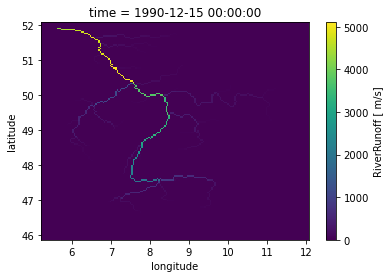

In [22]:
model_instance.get_value_as_xarray("RiverRunoff").plot()

If you want to know which variables are available, you can use

In [23]:
model_instance.output_var_names

('RiverRunoff',)

### Destroying the model

A model instance running in a container can take up quite a bit of resources on the system. When you're done with an experiment, it is good practice to always finalize the model. This will make sure the model properly performs any tear-down tasks and eventually the container will be destroyed.

In [24]:
model_instance.finalize()

## Observations

eWaterCycle also includes utilities to easily load observations. Currently, eWaterCycle systems provide access to GRDC and USGS data, and we're hoping to expand this in the future.

In [ ]:
import ewatercycle.observation.grdc

To load GRDC station data:

In [2]:
grdc_station_id = 6335020

observations, metadata = ewatercycle.observation.grdc.get_grdc_data(
    station_id=grdc_station_id,
    start_time="1990-01-01T00:00:00Z",  # or: model_instance.start_time_as_isostr
    end_time="1990-12-15T00:00:00Z",
    column="GRDC"
)

observations.head()

GRDC station 6335020 is selected. The river name is: RHINE RIVER.The coordinates are: (51.756918, 6.395395).The catchment area in km2 is: 159300.0. There are 0 missing values during 1990-01-01T00:00:00Z_1990-12-15T00:00:00Z at this station. See the metadata for more information.


,GRDC
time,
1990-01-01,2200.0
1990-01-02,1990.0
1990-01-03,1840.0
1990-01-04,1720.0
1990-01-05,1620.0


Since not all GRDC stations are complete, some information is stored in metadata to inform you about the data.

In [27]:
print(metadata)

{'grdc_file_name': '/lustre1/0/wtrcycle/comparison/GRDC/GRDC_GCOSGTN-H_27_03_2019/6335020_Q_Day.Cmd.txt', 'id_from_grdc': 6335020, 'file_generation_date': '2019-03-27', 'river_name': 'RHINE RIVER', 'station_name': 'REES', 'country_code': 'DE', 'grdc_latitude_in_arc_degree': 51.756918, 'grdc_longitude_in_arc_degree': 6.395395, 'grdc_catchment_area_in_km2': 159300.0, 'altitude_masl': 8.0, 'dataSetContent': 'MEAN DAILY DISCHARGE (Q)', 'units': 'm³/s', 'time_series': '1814-11 - 2016-12', 'no_of_years': 203, 'last_update': '2018-05-24', 'nrMeasurements': 'NA', 'UserStartTime': '1990-01-01T00:00:00Z', 'UserEndTime': '1990-12-15T00:00:00Z', 'nrMissingData': 0}


## Analysis

To easily analyse model output, eWaterCycle also includes an `analysis` module.

In [28]:
import ewatercycle.analysis

For example, we will plot a hydrograph of the model run and GRDC observations. To this end, we combine the two timeseries in a single dataframe

In [29]:
combined_discharge = observations
combined_discharge["wflow"] = output

(<Figure size 720x720 with 2 Axes>,
 (<AxesSubplot:title={'center':'Hydrograph'}, xlabel='time', ylabel='Discharge (m$^3$ s$^{-1}$)'>,
  <AxesSubplot:>))

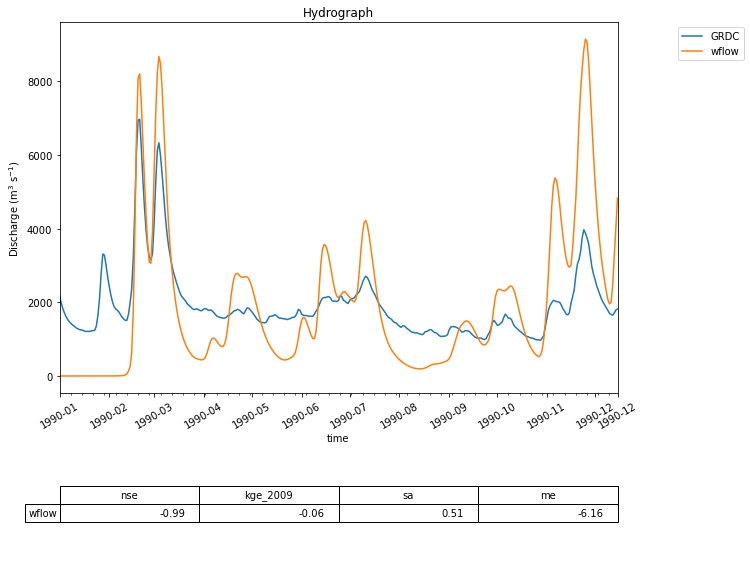

In [30]:
ewatercycle.analysis.hydrograph(
    discharge=combined_discharge,
    reference="GRDC",
)